Importing

In [2]:
import os, sys
import numpy as np
import pandas as pd

from scipy.stats import rankdata

%matplotlib inline
import matplotlib.pyplot as plt

import random
from utils.reliability_diagrams import *

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils.utils import show_batch, ToDeviceLoader
from utils.misc import plot_history
from models import models
import matplotlib.pyplot as plt
import matplotlib

from collections import OrderedDict

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from tqdm import tqdm
from datasets import cub, flowers, seals, litter
import pandas as pd

# Model processing
Defining file paths of model and dataset

Load model

25,173,163 total parameters.


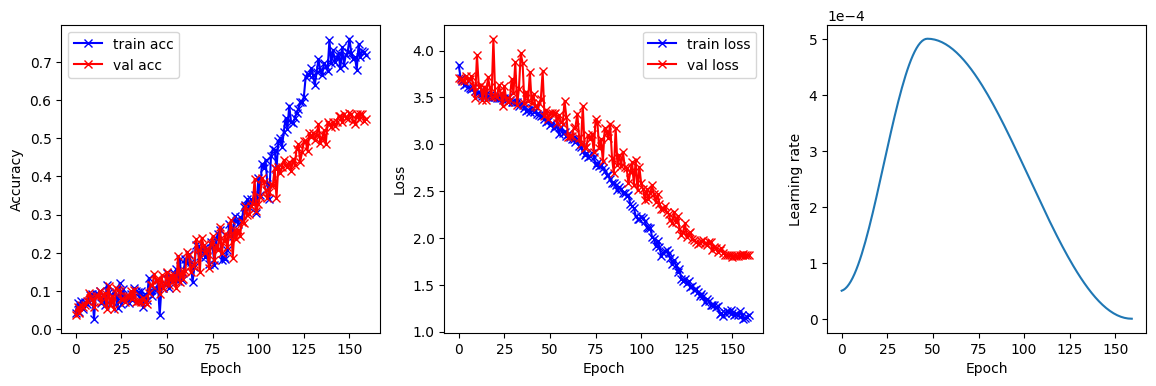

In [3]:
model_name = 'resnet18'
k = 1.5
img_size = 448
dataset = 'seals'

dict_path = f'.\\output\\{dataset}'
fig_path = os.path.join(dict_path, 'figures')
dict_name = f'{model_name}_{k}'
path = os.path.join(dict_path, dict_name + '.pt')

dataset = eval(dataset)
datasets = dataset.get_datasets(img_size, 0, download=False)
known = DataLoader(datasets['test_known'], batch_size=64,shuffle=False)
known = ToDeviceLoader(known, 'cuda')

# unknown = DataLoader(datasets['test_unknown'], batch_size=64,shuffle=True)
# unknown = ToDeviceLoader(unknown, 'cuda')
unknown = DataLoader(litter.get_dataset(image_size=img_size), batch_size=64,shuffle=True)
unknown = ToDeviceLoader(unknown, 'cuda')

model = models.get_model(model_name, k, 3, dataset.num_known_classes).to('cuda')
model.load_state_dict(torch.load(path))

# Get total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

history = pd.read_csv(os.path.join(dict_path, dict_name + '.csv'))
plot_history(history)

Visualise CNN

In [4]:
from mirror import mirror
from mirror.visualisations.web import *
import os
import torch
from datasets import seals, litter

seal_data = seals.get_datasets(img_size, 0, download=False)
seal, label = seal_data['test_known'][1]

litter_data = litter.get_dataset(img_size)
beach, label = litter_data[24]

# call mirror with the inputs and the model
mirror([beach, seal], model, visualisations=[BackProp, GradCam, DeepDream])

 * Serving Flask app 'mirror.App'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.69:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Apr/2023 19:12:44] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [11/Apr/2023 19:12:44] "GET /static/css/main.fd8c6979.chunk.css HTTP/1.1" 304 -
127.0.0.1 - - [11/Apr/2023 19:12:44] "GET /static/js/1.2f835df5.chunk.js HTTP/1.1" 304 -
127.0.0.1 - - [11/Apr/2023 19:12:44] "GET /static/js/main.e85ab74f.chunk.js HTTP/1.1" 304 -
127.0.0.1 - - [11/Apr/2023 19:12:44] "GET /api/inputs HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2023 19:12:45] "GET /api/model HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2023 19:12:45] "GET /api/visualisation HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2023 19:12:45] "GET /api/model/image/-9223363241308018996/-9223363241308018996/2293386093908042524/%3Cbuilt-in%20function%20id%3E/1 HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2023 19:12:45] "GET /api/model/image/-9223363241308018996/-9223363241308018996/2293386093908042524/%3Cbuilt-in%20function%2

Get logits from test datasets

In [5]:
known_labels = torch.tensor([])
pred_labels = torch.tensor([])
logits_known = torch.tensor([])
logits_unknown = torch.tensor([])

for x, y in tqdm(known):
    with torch.no_grad():
        logits = model(x)
        logits_known = torch.cat((logits_known, logits.cpu()))
        known_labels = torch.cat((known_labels, y.cpu()))
        pred_labels = torch.cat((pred_labels, logits.argmax(1).cpu()))

# num_batches = len(known)
# for i, (x, y) in enumerate(tqdm(unknown)):
#     with torch.no_grad():
#         logit_unknown = model(x)
#         logits_unknown = torch.cat((logits_unknown, logit_unknown.cpu()))


known_labels = known_labels.numpy()
pred_labels = pred_labels.numpy()

100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Get IDs of incorrectly classified images

In [ ]:
incorrect_ids = []
for index, i in enumerate(known_labels):
    if i != pred_labels[index]:
        incorrect_ids.append(index)

Find softmaxes at given temperature and give labels

In [ ]:
log_unknown, log_known = logits_unknown.numpy().max(1), logits_known.numpy().max(1)

# Get softmax probabilities
temperature = 1
softmax_known, softmax_unknown = F.softmax(logits_known/temperature, dim=1).numpy(), F.softmax(logits_unknown/temperature, dim=1).cpu().numpy()

confidence_known, confidence_unknown = softmax_known.max(1), softmax_unknown.max(1)

#randomly sample from unknown to match known length
# confidence_unknown = np.random.choice(confidence_unknown, len(confidence_known))
# log_unknown = np.random.choice(log_unknown, len(log_known))

open_labels = np.concatenate((np.ones(len(confidence_known)), np.zeros(len(confidence_unknown))))
logits = np.concatenate((log_known, log_unknown))
softmax = np.concatenate((confidence_known, confidence_unknown))

Get bar-chart of classes and accuracies

In [22]:
# make bar chart of each class and its accuracy
correct = dict()
classes = dict()

for index, i in enumerate(known_labels):
    if i not in correct:
        classes[i] = 1
    else:
        classes[i] += 1 

    if i == pred_labels[index]:
        if i not in correct:
            correct[i] = 1
        else:
            correct[i] += 1

for i in correct:
    correct[i] = correct[i]/classes[i]

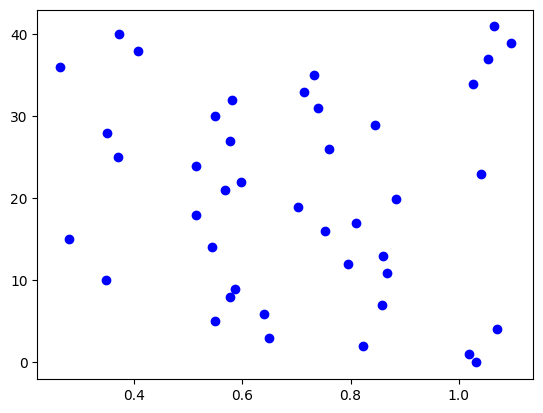

In [42]:
#plot histogram of classes
#plt.bar(classes.keys(), classes.values(), color='g')
# plt.bar(correct.keys(), correct.values(), color='b', edgecolor='black', linewidth=1.2)
# plt.xlabel('Class')
# plt.ylabel('Accuracy')
# plt.show()
#random array between 0 and 1

vary = 0.1
auroc = [i+(random.random()-0.5)*vary+num%2*vary**2 for num, i in enumerate(list(correct.values()))]
acc = [i+random.random()/10 for i in list(correct.values())]
plt.scatter(acc, auroc, color='b')

## Make reliability plot and get ECE

c:\Users\bauri\OneDrive - University of Bristol\Documents\RP3\utils\reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


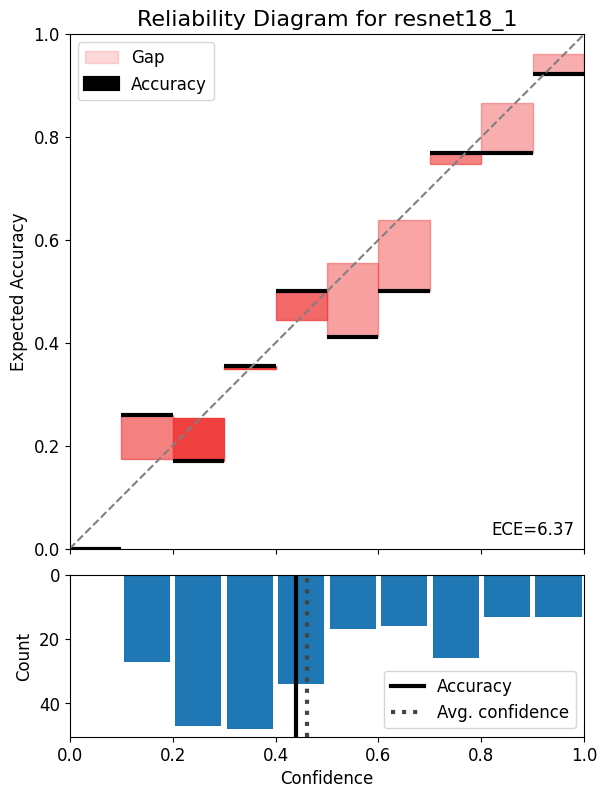

C:\Users\bauri\AppData\Local\Temp\ipykernel_4552\214541962.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [ ]:
plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

title = f'Reliability Diagram for {model_name}_{k}'

fig = reliability_diagram(known_labels, pred_labels, confidence_known, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)

fig.show()

# Get AUROC

AUROC:  0.5607019907288271


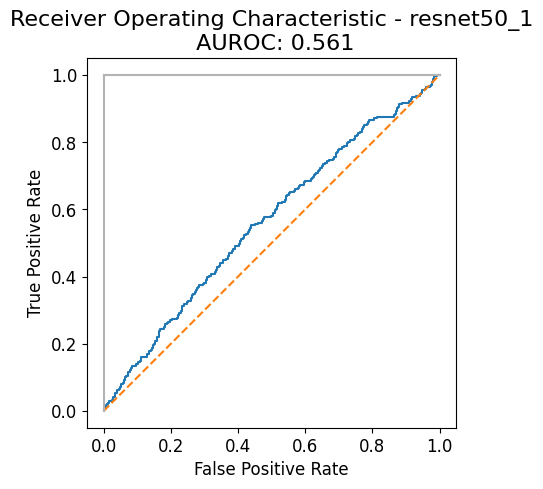

In [ ]:
# Shuffle the data, keeping the labels and softmax scores in sync.
temp = list(zip(open_labels, softmax))
random.shuffle(temp)
labels_open, softmax = zip(*temp)
labels_open, softmax = list(labels_open), list(softmax)

# Compute the ROC curve and AUC.
fpr_sm, tpr_sm, thresholds_sm = roc_curve(labels_open, softmax)
#fpr_log, tpr_log, thresholds_log = roc_curve(labels_open, logits)
auroc = roc_auc_score(labels_open, softmax)
print('AUROC: ', auroc)

ax = plt.subplot(1,1,1)

plt.title(f'Receiver Operating Characteristic - {model_name}_{k}\n AUROC: {auroc:.3f}')
plt.plot(fpr_sm, tpr_sm)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
ax.set_aspect('equal', adjustable='box')
plt.show()

Finding best threshold for osr inference (max|fp-tp|)

In [ ]:
diff = 0

threshold = 0
for (fp,tp,thresh) in zip(fpr_sm, tpr_sm, thresholds_sm):
    if abs(fp-tp) > diff:
        diff = abs(fp-tp)
        threshold = thresh

print(threshold)

0.36526304


Find accuracy at threshold

In [ ]:
correct = 0
for i in zip(softmax, labels_open):

    if (i[0] >= threshold and i[1] == 1) or (i[0] <= threshold and i[1] == 0):
        correct += 1

accuracy = correct/len(softmax)
print(accuracy)

0.6684491978609626


Inference timer on CPU

In [ ]:
from torchvision.models.resnet import *

# k=2.5
# model = models.get_model('resnet18', k, 3, cub.num_known_classes).to('cuda')


data = DataLoader(datasets['test_known'], batch_size=64,shuffle=True)
model.to('cpu')

import time
start_time = time.time()
for i in range(100):
    x, y = next(iter(data))
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(1)
        print(pred, y)
    break

time_elapsed = time.time() - start_time
print(f"--- {(time_elapsed):>0.1f} seconds ---")
print(f"=> {time_elapsed/64} seconds per image")

#Send model back to GPU
model.to('cuda')

tensor([34, 17, 19, 25, 15, 24, 11,  0,  5, 20,  9,  0, 25, 23, 18, 12,  1, 23,
        34,  4, 36, 32, 24, 30, 28, 17, 12, 14,  6, 39, 17, 30, 28, 11, 30, 39,
        30,  5, 39, 34, 27,  5, 24, 11, 17,  5, 27,  7, 22, 25, 38, 13,  2, 16,
         7,  4, 33, 41, 16, 10, 10, 15,  4,  6]) tensor([ 3, 32, 18, 35, 33, 24, 21, 36, 31, 41, 16, 24, 12, 15,  5, 39,  1, 35,
        34,  4, 14, 21,  2, 30, 10, 20, 12, 39,  6, 27, 23,  3, 13, 11, 30, 25,
        37,  5, 39, 14, 23,  5, 24, 34, 42,  7, 37, 32, 22, 25, 38, 28,  8, 23,
         7, 40, 33, 41, 22, 10, 10, 27,  9, 27])
--- 10.9 seconds ---
=> 0.17099939659237862 seconds per image


ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (conv2_1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2_2): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=